<a href="https://colab.research.google.com/github/Kazuhiko-Miyata/sinple_mnist_predictmodel/blob/main/sinple_mnist_predictmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **手書き文字画像の確認**
「scikit-learn」というライブラリから手書き数字の画像データを読み込み表示させる。

画像サイズは8*8ピクセルでモノクロ。

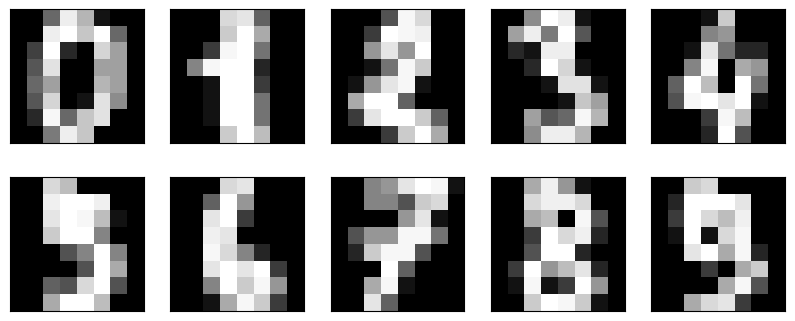

データの形状: (1797, 64)
ラベル: [0 1 2 3 4 5 6 7 8 9]


In [10]:
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10 #表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False) #軸を非表示に
    ax.get_yaxis().set_visible(False)
plt.show()

print("データの形状:", digits_data.data.shape)
print("ラベル:", digits_data.target[:n_img])

8*8ピクセルとサイズは小さいが、0から9までの手書き数字の画像が表示された。このような手書き数字の画像が、このデータセットには1797枚含まれている。

また、各画像は書かれた数字を表すラベルとペアになっている。今回はこのラベルを正解として使用。

**データを訓練用とテスト用に分割**

scikit-learnのtrain_test_splitを使って、データを訓練用とテスト用に分割する。訓練データを使ってニューラルネットワークのモデルを訓練し、テストデータを使って訓練したモデルを検証する。

In [11]:
import torch
from sklearn.model_selection import train_test_split

digit_images = digits_data.data
labels = digits_data.target
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels)#25%がテスト用

#Tensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32)
#入力:訓練用
t_train = torch.tensor(t_train, dtype=torch.int64)
#正解:訓練用
x_test = torch.tensor(x_test, dtype=torch.float32)
#入力:テスト用
t_test = torch.tensor(t_test, dtype=torch.int64)
#正解:テスト用

## **モデルの構築**
nnモジュールの**Sequential()クラス**によりニューラルネットワークのモデルを構築する。初期値としてnnモジュールに定義されている層を入力に近い層から順番に並べる。

**nn.Linear()関数**はニューロンが隣接する層のすべてのニューロンとつながる「全結合層」で、以下のように記述する



```
nn.Linear(#層への入力数, #層のニューロン数)
```


また、nnモジュールでは活性化関数を層のように扱うことができる。
**nn.ReLU()関数**を配置することで、活性化関数ReLUによる処理が行われる。



In [12]:
from torch import nn

net = nn.Sequential(
    nn.Linear(64, 32),#全結合層
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


3つの結合層の間に、活性化関数ReLUが挟まれている。最後の出力層のニューロン数は10だが、これは分類する数字が0～9なので10クラス分類になるため。

## **学習**
誤差を最小化するように、パラメータを何度も繰り返し調整する。今回は損失関数に**nn.CrossEntropyLoss()関数**（ソフトマックス関数＋交差エントロピー関数）を、最適化アルゴリズムにSDGを設定する。


順伝播は訓練データ、テストデータ両者で行い誤差を計算する。逆伝播を行うのは訓練データのみ。

In [13]:
from torch import optim

#ソフトマックス関数+交差エントロピー関数
loss_fnc = nn.CrossEntropyLoss()

#SDG　モデルのパラメータを渡す
optimizer = optim.SGD(net.parameters(), lr=0.01) #学習率は0.01

#損失のログ
record_loss_train = []
record_loss_test = []

#訓練データを1000回使う
for i in range(1000):
  #パラメータの勾配を0に
  optimizer.zero_grad()

  #順伝播
  y_train = net(x_train)
  y_test = net(x_test)

  #誤差を求めて記録する
  loss_train = loss_fnc(y_train, t_train)
  loss_test = loss_fnc(y_test, t_test)
  record_loss_train.append(loss_train.item())
  record_loss_test.append(loss_test.item())

  #逆伝播
  loss_train.backward()

  #パラメータの更新
  optimizer.step()

  if i%100 == 0: #100回ごとに経過を表示
      print("Epoch:", i, "Loss_Train:", loss_train.item(), "Loss_Test:", loss_test.item())


Epoch: 0 Loss_Train: 2.5574281215667725 Loss_Test: 2.5960533618927
Epoch: 100 Loss_Train: 0.9915700554847717 Loss_Test: 1.0731433629989624
Epoch: 200 Loss_Train: 0.4722011685371399 Loss_Test: 0.5472731590270996
Epoch: 300 Loss_Train: 0.29404833912849426 Loss_Test: 0.3681710362434387
Epoch: 400 Loss_Train: 0.2070455700159073 Loss_Test: 0.28641486167907715
Epoch: 500 Loss_Train: 0.15785980224609375 Loss_Test: 0.24334248900413513
Epoch: 600 Loss_Train: 0.1258610039949417 Loss_Test: 0.2191070020198822
Epoch: 700 Loss_Train: 0.10367681086063385 Loss_Test: 0.205204576253891
Epoch: 800 Loss_Train: 0.08774108439683914 Loss_Test: 0.19654275476932526
Epoch: 900 Loss_Train: 0.07562911510467529 Loss_Test: 0.191375270485878


以下の個所では**順伝播**の処理が行われる



```
y_train = net(x_train)

y_test = net(x_test
```

以下の個所では**逆伝播**の処理が行われる


```
loss_train.backward()
```

誤差（loss_train）のbackward()メソッドによりバックプロパゲーションが行われてすべてのパラメータに勾配が計算される。

以下の記述で最適化アルゴリズムに基づいてすべてのパラメータが更新される


```
optimizer.step()
```

順伝播、逆伝播、パラメータの更新を繰り返すことで、モデルは次第に適切な出力を返すように訓練される。




## **誤差の推移**
訓練データ、テストデータの記録を、matplotlibを使ってグラフ表示する。

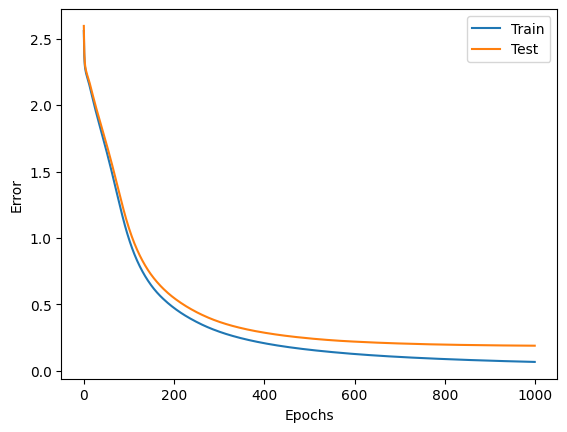

In [14]:
plt.plot(range(len(record_loss_train)),
         record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)),
         record_loss_test, label="Test")

plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## **正解率**
モデルの性能を把握するため、テストデータを使って正解率を測定

In [15]:
y_test = net(x_test)
count = (y_test.argmax(1) == t_test).sum().item()
print("正解率:", str(count/len(y_test)*100) + "%")

正解率: 94.88888888888889%


## **訓練済みのモデルを使った予測**
手書き文字画像を入力し、モデルが機能する事を確認

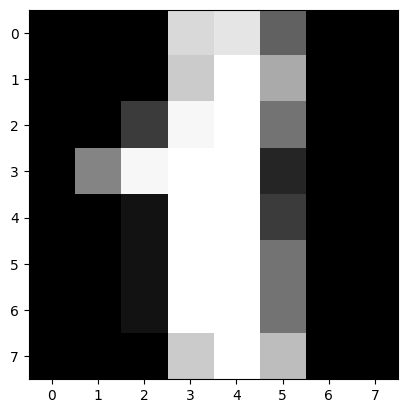

正解率: 1 予測結果: 1


In [16]:
#入力画像
img_id = 1 #予測したい数値を入力
x_pred = digit_images[img_id]
image = x_pred.reshape(8, 8)
plt.imshow(image, cmap="Greys_r")
plt.show()

x_pred = torch.tensor(x_pred, dtype=torch.float32)
y_pred = net(x_pred)
print("正解率:", labels[img_id], "予測結果:", y_pred.argmax().item())

訓練済みモデルは、入力画像を正しく分類できている。

# **演習**
### **データを訓練用とテスト用に分割**
データを訓練用とテスト用に分割する

In [17]:
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits_data = datasets.load_digits()

digit_images = digits_data.data
labels =digits_data.target
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels)

x_train = torch.tensor(x_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.int64)
x_test = torch.tensor(x_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.int64)


**モデルの構築**

In [18]:
from torch import nn

net = nn.Sequential(
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 10),
)
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


## **学習**

In [19]:
from torch import optim

#交差エントロピー誤差関数
loss_fcn = nn.CrossEntropyLoss()

#最適化アルゴリズム
optimizer = optim.SGD(net.parameters(), lr=0.001)

#損失のログ
record_loss_train = []
record_loss_test = []

#1000エポック学習
for i in range(1000):

    #勾配を0に
    optimizer.zero_grad()

    #順伝播
    y_train = net(x_train)
    y_test = net(x_test)

    #誤差を求める
    loss_train = loss_fnc(y_train, t_train)
    loss_test = loss_fnc(y_test, t_test)
    record_loss_train.append(loss_train.item())
    record_loss_test.append(loss_test.item())

    #逆伝播(勾配を求める)
    loss_train.backward()

    #パラメータの更新
    optimizer.step()

    if i%100 ==0:
        print("Epoch:", i, "Loss_Train:", loss_train.item(), "Loss_test:", loss_test.item())

Epoch: 0 Loss_Train: 2.568513870239258 Loss_test: 2.512409210205078
Epoch: 100 Loss_Train: 1.8935661315917969 Loss_test: 1.877031922340393
Epoch: 200 Loss_Train: 1.522770881652832 Loss_test: 1.5157370567321777
Epoch: 300 Loss_Train: 1.2006944417953491 Loss_test: 1.2010830640792847
Epoch: 400 Loss_Train: 0.9454972743988037 Loss_test: 0.9528270959854126
Epoch: 500 Loss_Train: 0.7629024982452393 Loss_test: 0.7755266427993774
Epoch: 600 Loss_Train: 0.6332455277442932 Loss_test: 0.6497853994369507
Epoch: 700 Loss_Train: 0.538990318775177 Loss_test: 0.5592434406280518
Epoch: 800 Loss_Train: 0.46870318055152893 Loss_test: 0.49262210726737976
Epoch: 900 Loss_Train: 0.41481634974479675 Loss_test: 0.44226688146591187


## **誤差の推移**

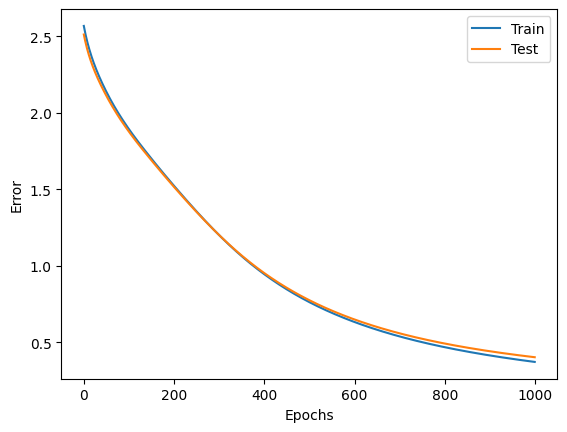

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## **正解率**

In [21]:
y_test = net(x_test)
count = (y_test.argmax(1) == t_test).sum().item()
print("正解率:", str(count/len(y_test)*100) + "%")

正解率: 92.22222222222223%
